# PowerCo Case

In [2]:
# import libraries
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import matplotlib.ticker as mtick
import shap

# balance dataset
from imblearn.over_sampling import SMOTE

# model
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import xgboost as xgb
 
# decision tree plot
import pydotplus
from IPython.display import Image

# performance metrics
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt

In [3]:
# load data
price = pd.read_csv('ml_case_training_hist_data.csv')
data = pd.read_csv('ml_case_training_data.csv')
label = pd.read_csv('ml_case_training_output.csv')

### Price Data

In [4]:
# display data
pd.set_option('display.max_columns', 100)
price.head(2).style

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.000000,0.000000,44.266931,0.000000,0.000000
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.000000,0.000000,44.266931,0.000000,0.000000


In [5]:
price.shape

(193002, 8)

In [6]:
# check if there are duplicates
price[price.duplicated()].shape[0]

0

In [7]:
# check data types and missing values
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            193002 non-null  object 
 1   price_date    193002 non-null  object 
 2   price_p1_var  191643 non-null  float64
 3   price_p2_var  191643 non-null  float64
 4   price_p3_var  191643 non-null  float64
 5   price_p1_fix  191643 non-null  float64
 6   price_p2_fix  191643 non-null  float64
 7   price_p3_fix  191643 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


Some observations:
- Wrong data type: price_date
- Missing values: price_p1_var to price_p3_fix

In [8]:
# convert to the right data type
price['price_date'] = pd.to_datetime(price['price_date'], format='%Y-%m-%d')

In [9]:
# display statistics 
price.describe().style

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.140991,0.054412,0.030712,43.325546,10.698201,6.455436
std,0.025117,0.050033,0.036335,5.437952,12.856046,7.782279
min,0.000000,0.000000,0.000000,-0.177779,-0.097752,-0.065172
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101780,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


Some observations:
- Minimum values for price of power is negative.
- Mean and median varies much for some columns such as price_p2_fix, price_p3_fix.

In [10]:
price.query('price_p1_fix < 0 | price_p2_fix < 0 | price_p2_fix < 0').shape[0]

10

There are 10 observations has negative values --> corrupted data rather than 'discount price' --> absolute(). 

In [11]:
price.loc[price['price_p1_fix'] < 0, 'price_p1_fix'] = price['price_p1_fix'].abs()
price.loc[price['price_p2_fix'] < 0, 'price_p2_fix'] = price['price_p2_fix'].abs()
price.loc[price['price_p3_fix'] < 0, 'price_p3_fix'] = price['price_p3_fix'].abs()

In [12]:
# # how much are missing values?
# miss_val = price[['price_p1_var','price_p2_var','price_p3_var','price_p1_fix','price_p2_fix','price_p3_fix']]
# pd.DataFrame({'Mising Values(%)': (miss_val.isnull().sum()/len(miss_val.index)*100).round(3)})

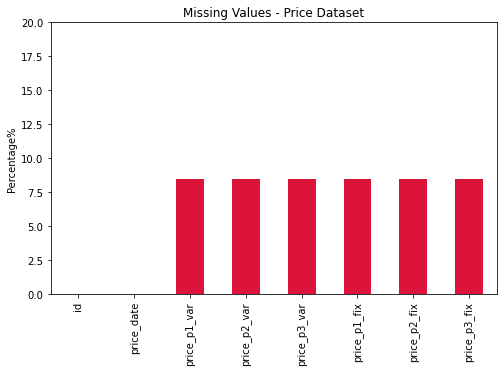

In [13]:
# plot missing data
( price.isnull().sum() / len(data)*100 ).plot.bar(figsize=(8,5), color='crimson')
plt.ylabel('Percentage%')
plt.ylim(0, 20)
plt.title('Missing Values - Price Dataset');

Not so much missing data and they can be filled with median values.

In [14]:
price.loc[price['price_p1_var'].isnull(),'price_p1_var'] = price['price_p1_var'].median()
price.loc[price['price_p2_var'].isnull(),'price_p2_var'] = price['price_p2_var'].median()
price.loc[price['price_p3_var'].isnull(),'price_p3_var'] = price['price_p3_var'].median()
price.loc[price['price_p1_fix'].isnull(),'price_p1_fix'] = price['price_p1_fix'].median()
price.loc[price['price_p2_fix'].isnull(),'price_p2_fix'] = price['price_p2_fix'].median()
price.loc[price['price_p3_fix'].isnull(),'price_p3_fix'] = price['price_p3_fix'].median()

### Customer Data

In [15]:
# dimensions of customer dataset
data.shape

(16096, 32)

In [16]:
# display data
data.head(2).style

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,nan,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,nan,2012-11-07,2015-11-09,nan,nan,nan,nan,26520.300000,10025,0.000000,359.290000,0.095919,0.088347,58.995952,f,831.800000,-41.760000,-41.760000,1,1732.360000,3,ldkssxwpmemidmecebumciepifcamkci,180.000000
1,24011ae4ebbe3035111d65fa7c15bc57,nan,nan,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,nan,nan,2015-06-23,nan,nan,nan,nan,0.000000,0,0.000000,1.780000,0.114481,0.098142,40.606701,t,0.000000,25.440000,25.440000,2,678.990000,3,lxidpiddsbxsbosboudacockeimpuepw,43.648000


In [17]:
# check if there are duplicates
data[data.duplicated()].shape[0]

0

In [18]:
# check data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16096 non-null  object 
 1   activity_new              6551 non-null   object 
 2   campaign_disc_ele         0 non-null      float64
 3   channel_sales             11878 non-null  object 
 4   cons_12m                  16096 non-null  int64  
 5   cons_gas_12m              16096 non-null  int64  
 6   cons_last_month           16096 non-null  int64  
 7   date_activ                16096 non-null  object 
 8   date_end                  16094 non-null  object 
 9   date_first_activ          3508 non-null   object 
 10  date_modif_prod           15939 non-null  object 
 11  date_renewal              16056 non-null  object 
 12  forecast_base_bill_ele    3508 non-null   float64
 13  forecast_base_bill_year   3508 non-null   float64
 14  foreca

Some observations:
- Drop campaign_disc_ele since there is no values in this column.
- Wrong data type: date_activ, date_end, date_first_activ, date_modif_prod, date_renewal --> datetime, not object.
- Most of columns has missing values, some have a considerable amount of missing values such as forecast_base_bill_ele, forecast_base_bill_year, forecast_bill_12m, forecast_cons (over 75%) --> drop.  

In [19]:
# verify campaign_disc_ele if is empty
data["campaign_disc_ele"].isnull().values.all()

True

In [20]:
# drop column
data.drop('campaign_disc_ele', axis=1, inplace=True)

In [21]:
# convert data type
convert_objects = ['date_activ','date_end','date_first_activ','date_modif_prod','date_renewal']
for c in convert_objects:
    data[c] = pd.to_datetime(data[c], format='%Y-%m-%d')

In [22]:
# display statistics 
data.describe().style

,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max
count,16096.000000,16096.000000,16096.000000,3508.000000,3508.000000,3508.000000,3508.000000,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000
mean,194804.384630,31911.636742,19461.536158,335.843857,335.843857,3837.441866,206.845165,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131
std,679515.083441,177588.456233,82356.756560,649.406000,649.406000,5425.744327,455.634288,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421
min,-125276.000000,-3037.000000,-91386.000000,-364.940000,-364.940000,-2503.480000,0.000000,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000
25%,5906.250000,0.000000,0.000000,0.000000,0.000000,1158.175000,0.000000,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000
50%,15332.500000,0.000000,901.000000,162.955000,162.955000,2187.230000,42.215000,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000
75%,50221.500000,0.000000,4127.000000,396.185000,396.185000,4246.555000,228.117500,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000
max,16097108.000000,4188440.000000,4538720.000000,12566.080000,12566.080000,81122.630000,9682.890000,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000


Some observations:
- The minimum consupmtion of electricity and gas (yearly/monthly) are negative --> might be client companies are energy producer.
- Highly skewed data as the distance between percentiles are substantial.

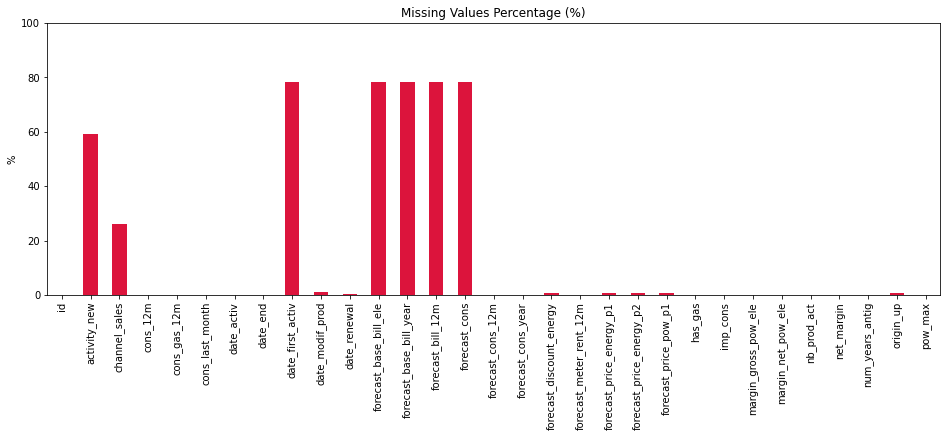

In [23]:
# plot missing data
(data.isnull().sum() / len(data)*100 ).plot.bar(figsize=(16,5), color='crimson')
plt.xlabel('')
plt.ylabel('%')
plt.ylim(0, 100)
plt.title('Missing Values Percentage (%)');

*Drop features with more than 70% of missing values*

In [24]:
data.drop(['date_first_activ','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m','forecast_cons'], axis=1, inplace=True)

### Label

In [25]:
# dimensions of outcome dataset
label.shape

(16096, 2)

In [26]:
# display data
label.head(2).style

,id,churn
0,48ada52261e7cf58715202705a0451c9,0
1,24011ae4ebbe3035111d65fa7c15bc57,1


In [27]:
# check if there are duplicates
label[label.duplicated()].shape[0]

0

In [28]:
# check data types and missing values
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      16096 non-null  object
 1   churn   16096 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 251.6+ KB


Label data is in good quality (no missing value), no data cleaning is needed.

## Combine Customer Data with Outcome label

In [29]:
train = pd.merge(data, label, on='id')
train.head(2).style

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07 00:00:00,2016-11-06 00:00:00,2012-11-07 00:00:00,2015-11-09 00:00:00,26520.300000,10025,0.000000,359.290000,0.095919,0.088347,58.995952,f,831.800000,-41.760000,-41.760000,1,1732.360000,3,ldkssxwpmemidmecebumciepifcamkci,180.000000,0
1,24011ae4ebbe3035111d65fa7c15bc57,nan,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15 00:00:00,2016-06-15 00:00:00,NaT,2015-06-23 00:00:00,0.000000,0,0.000000,1.780000,0.114481,0.098142,40.606701,t,0.000000,25.440000,25.440000,2,678.990000,3,lxidpiddsbxsbosboudacockeimpuepw,43.648000,1


## Exploratory Data Analysis

### Churn

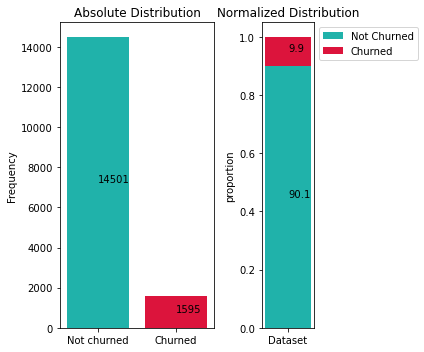

In [30]:
keys, counts = np.unique(label.churn, return_counts=True)
counts_norm = counts / counts.sum()

fig = plt.figure(figsize = (6,5))
gs = gridspec.GridSpec(1,2, width_ratios=[3,1])

# absolute values
ax1 = plt.subplot(gs[0])
ax1 = plt.bar(['Not churned','Churned'], counts, color=['lightseagreen','crimson'])
ax1 = plt.title('Absolute Distribution')
ax1 = plt.ylabel('Frequency')
ax1 = plt.text(['Not churned'], counts[0]/2, counts[0])
ax1 = plt.text(['Churned'], counts[1]/2, counts[1])

# normalized values
ax2 = plt.subplot(gs[1])
ax2 = plt.bar(['Dataset'], counts_norm[0], label='Not Churned', color='lightseagreen')
ax2 = plt.bar(['Dataset'], counts_norm[1], bottom=counts_norm[0], label='Churned', color='crimson')
ax2 = plt.title('Normalized Distribution')
ax2 = plt.ylabel('proportion')
ax2 = plt.text(['Dataset'], counts_norm[0]/2, str((counts_norm[0]*100).round(1)))
ax2 = plt.text(['Dataset'], counts_norm[1]/2 + counts_norm[0], str((counts_norm[1]*100).round(1)))
ax2 = plt.legend(bbox_to_anchor=(1,1))

plt.tight_layout();

Churned customers is about 10% by March 2016.

### Sales Channel

In [31]:
viz_channel = train.groupby(['channel_sales','churn'])['churn'].count().unstack().sort_values(by=1, ascending=False)
viz_channel = viz_channel[:5].copy()
viz_channel = viz_channel.fillna(0)

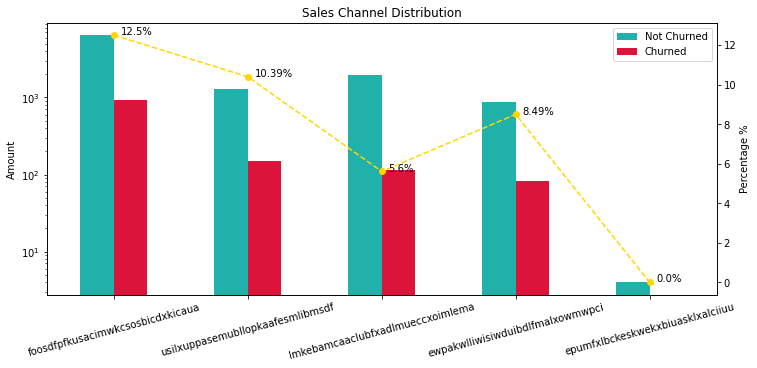

In [32]:
# absolute visualization
ax1 = viz_channel.plot(kind='bar', figsize=(12,5), color=['lightseagreen','crimson'], rot=15)
ax1.set_xlabel('')
ax1.set_ylabel('Amount')
ax1.set_yscale('log')
ax1.legend(['Not Churned','Churned'])
plt.title('Sales Channel Distribution')

ax2 = ax1.twinx()
per = (viz_channel[1] * 100 / (viz_channel[0]+viz_channel[1])).round(2)
ax2.plot(per, marker='o', linestyle='--',  color='gold')
ax2.set_ylabel('Percentage %')

for c in range(0,5):
    ax2.text(c+0.05, per[c]+0.01, str(per[c])+'%');

### Consumption

In [33]:
def plot_consumption(df, column, bins=20):
    dt = pd.DataFrame({'Not Churned': df[df['churn'] == 0][column],
                       'Churned': df[df['churn'] == 1][column]})
    dt[['Not Churned','Churned']].plot(figsize=(8,5), kind='hist', 
                                       bins=bins, stacked=True, color=['lightseagreen','crimson']);

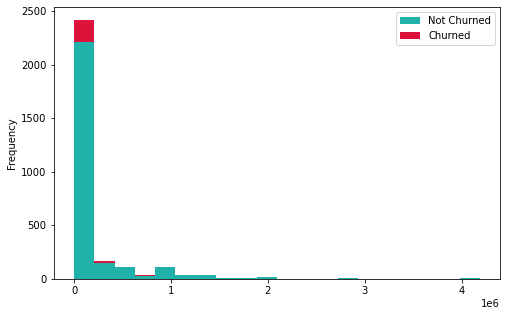

In [34]:
# gas consumption of the past 12 months
plot_consumption(train[train['has_gas'] == 't'],'cons_gas_12m')

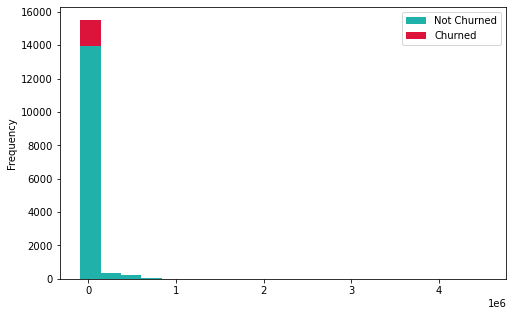

In [35]:
# electricity consumption of last month
plot_consumption(train, 'cons_last_month')

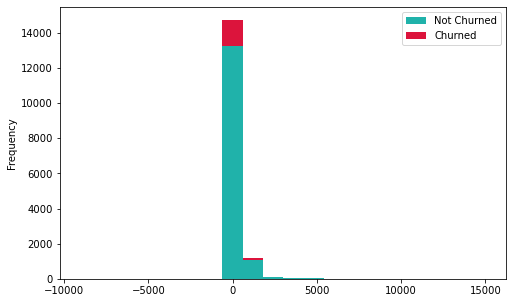

In [36]:
# current paid consumption
plot_consumption(train, 'imp_cons')

Consumption data is highly skewed to the right. The values to the far right is likely to be outliers --> use boxplot to check if there are outliers.

**Outliers**

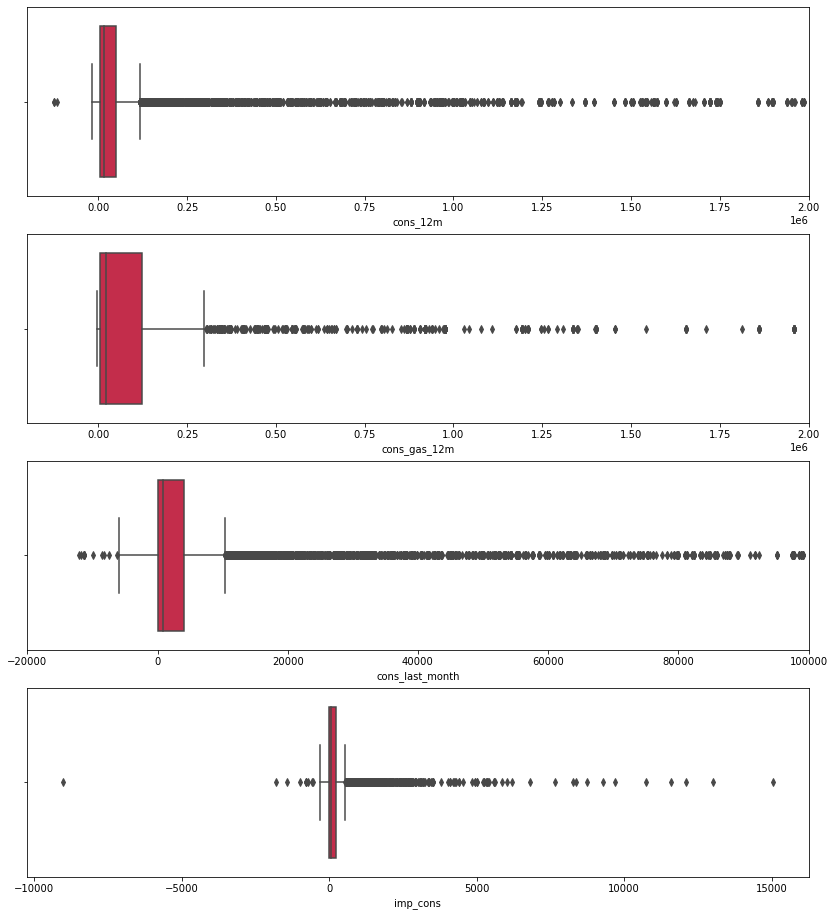

In [37]:
fig, axs = plt.subplots(nrows=4, figsize=(14,16))
# Plot histogram
sns.boxplot(x = train["cons_12m"], ax=axs[0], color='crimson')
sns.boxplot(x = train[train["has_gas"] == "t"]["cons_gas_12m"], ax=axs[1], color='crimson')
sns.boxplot(x = train["cons_last_month"], ax=axs[2], color='crimson')
sns.boxplot(x = train["imp_cons"], ax=axs[3], color='crimson')

# set x-axis limit
axs[0].set_xlim(-200000, 2000000)
axs[1].set_xlim(-200000, 2000000)
axs[2].set_xlim(-20000, 100000);

It is clear that those are highly skewed distribution and several outliers.

### Dates

In [38]:
def plot_dates(df, col, figsize=(20,8)):
    month = df[[col, 'churn', 'id']].set_index(col).groupby([pd.Grouper(freq='M'),'churn']).count().unstack(level=1)
    ax = month.plot(kind='bar', stacked=True, figsize=figsize, rot=0, color=['lightseagreen', 'crimson'])
    plt.ylabel('Number of Companies')
    plt.legend(['Not Churned', 'Churned'], loc='best')
    plt.xlabel('')
    ax.set_xticklabels(map(lambda x: x_format(x), month.index));
    
def x_format(label):
    m = label.month_name()[:1]
    if label.month_name() == 'January':
        m += f'\n{label.year}'
    return m


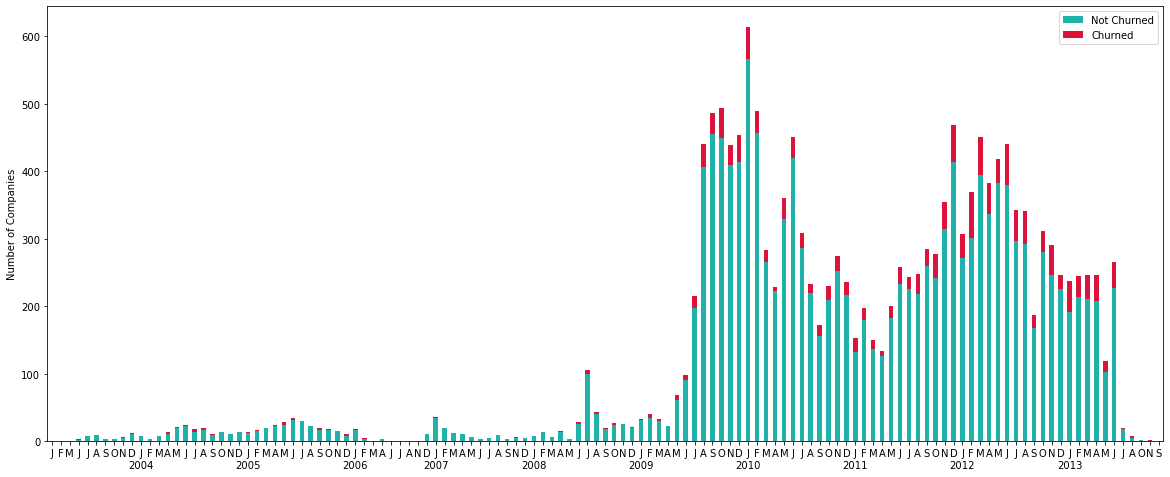

In [39]:
plot_dates(train, 'date_activ')

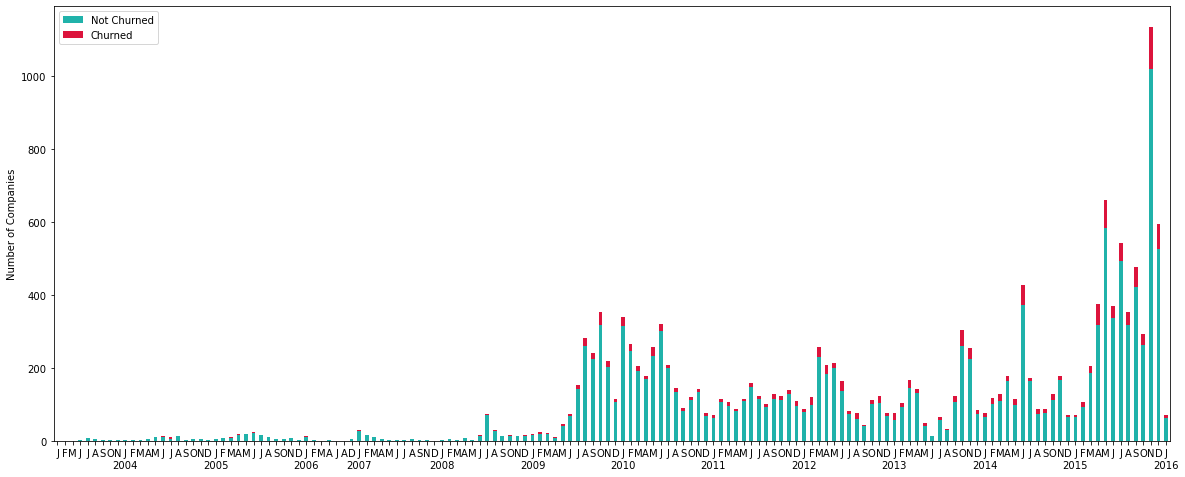

In [40]:
plot_dates(train, 'date_modif_prod')

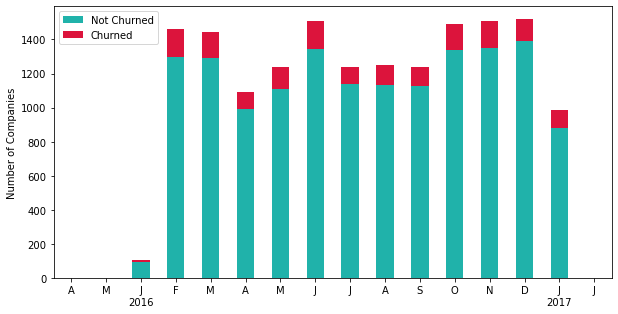

In [41]:
plot_dates(train, 'date_end', figsize=(10,5))

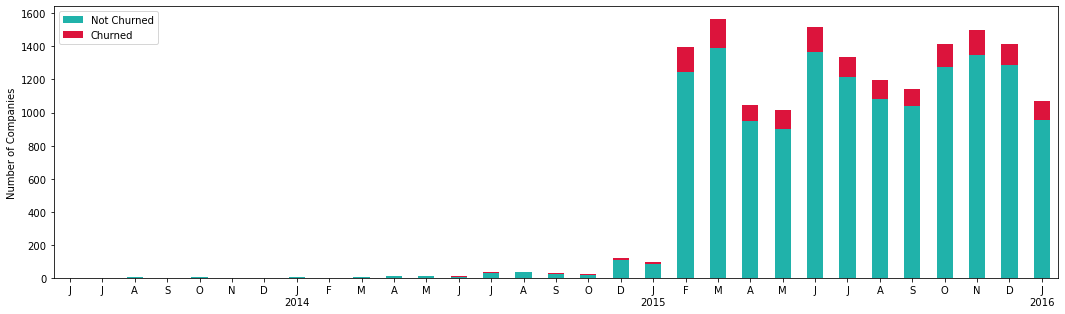

In [42]:
plot_dates(train, 'date_renewal', figsize=(18,5))

Date and churn distribution in these visualization do not provide any insights. Duration will be created out of these dates to verify if there are any pattern.

### Focast Data

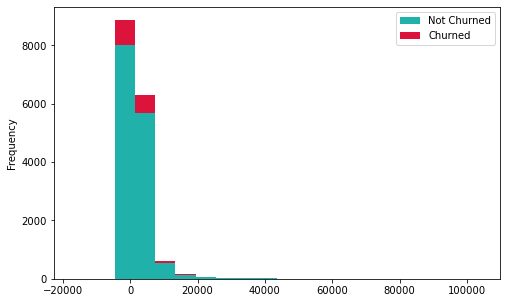

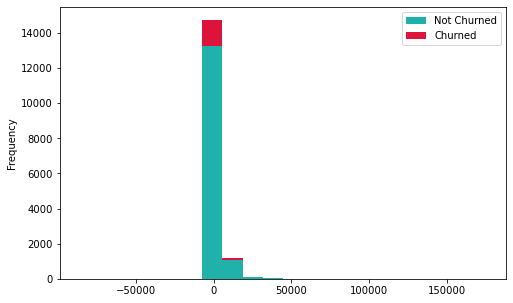

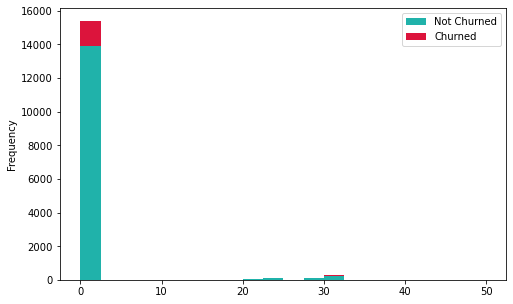

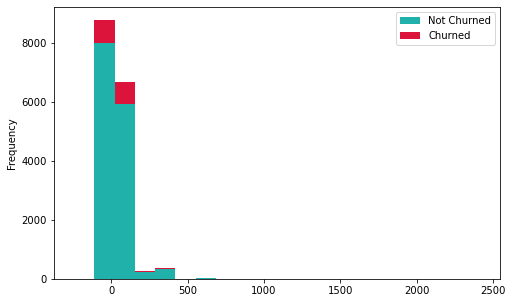

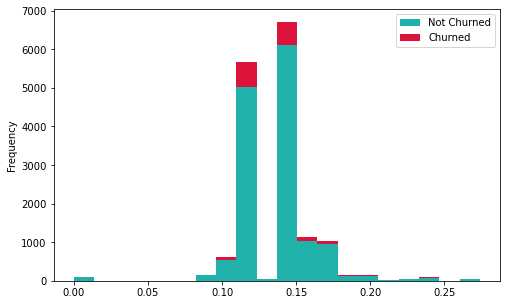

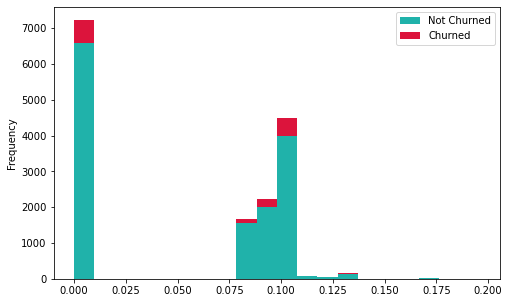

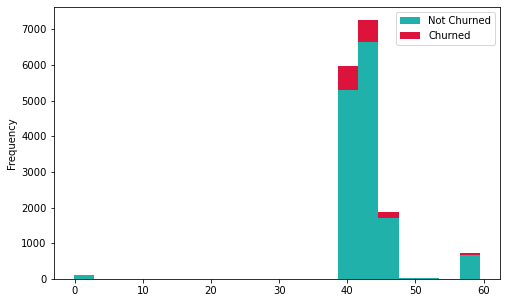

In [43]:
plot_consumption(train, 'forecast_cons_12m')
plot_consumption(train, 'forecast_cons_year')
plot_consumption(train, 'forecast_discount_energy')
plot_consumption(train, 'forecast_meter_rent_12m')
plot_consumption(train, 'forecast_price_energy_p1')
plot_consumption(train, 'forecast_price_energy_p2')
plot_consumption(train, 'forecast_price_pow_p1');

These forecast features are highly skewed.

### Contract Type

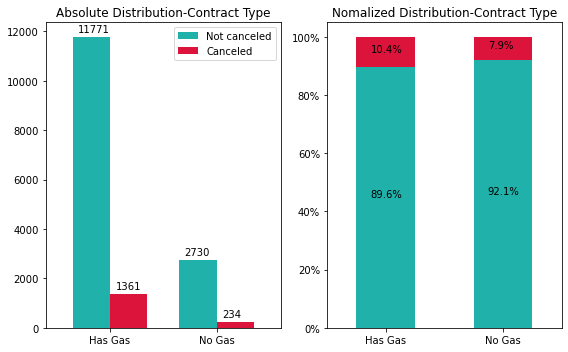

In [44]:
fig = plt.figure(figsize=(8,5))

# absolute
plt.subplot(1,2,1)
ax1 = train.groupby(['has_gas','churn'])['has_gas'].count().unstack().plot.bar(ax=plt.gca(),width=0.7,legend=None, color=['lightseagreen','crimson'])
plt.title('Absolute Distribution-Contract Type')
plt.xlabel(None)
plt.legend(['Not canceled','Canceled'])
ax1.set_xticklabels(['Has Gas', 'No Gas'], rotation=0)
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.05, p.get_height() + 200))

# normalized
plt.subplot(1,2,2)
ax2 = train.groupby(['has_gas','churn'])['has_gas'].count().groupby(level=0).apply(
    lambda x: 100*x / x.sum()).unstack().plot.bar(stacked=True,ax=plt.gca(),color=['lightseagreen','crimson'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.get_legend().remove()
plt.title('Nomalized Distribution-Contract Type')
plt.xlabel(None)
ax2.set_xticklabels(['Has Gas', 'No Gas'], rotation=0)

for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.12, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.12, q.get_height()/2+p.get_height()))

plt.tight_layout();

### Margin

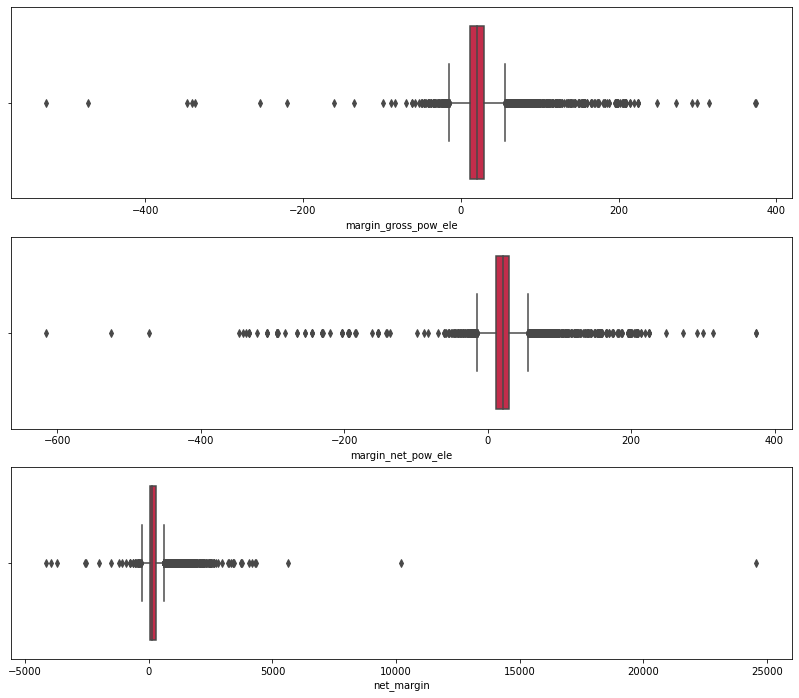

In [45]:
fig, axs = plt.subplots(nrows=3, figsize=(14,12))
# Plot histogram
sns.boxplot(x = train['margin_gross_pow_ele'], ax=axs[0], color='crimson')
sns.boxplot(x = train['margin_net_pow_ele'], ax=axs[1], color='crimson')
sns.boxplot(x = train['net_margin'], ax=axs[2], color='crimson');

## Data Engineering

### Missing Data

Only customer dataset has missing values

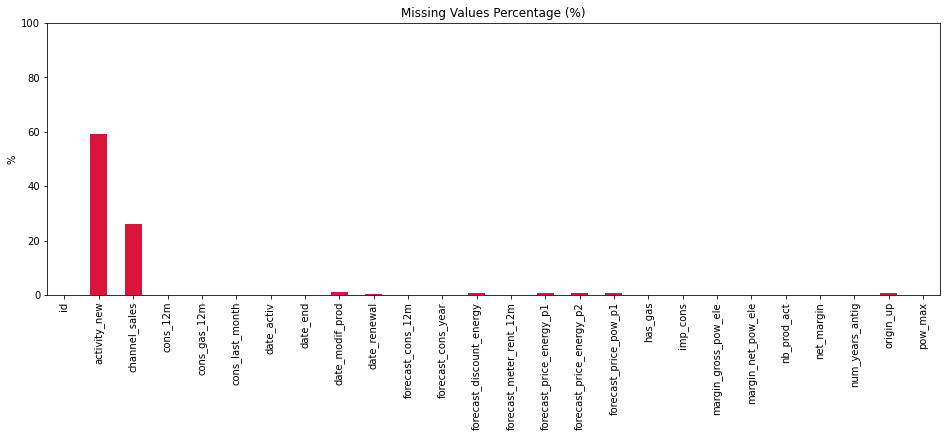

In [46]:
# plot missing data
(data.isnull().sum() / len(data)*100 ).plot.bar(figsize=(16,5), color='crimson')
plt.xlabel('')
plt.ylabel('%')
plt.ylim(0, 100)
plt.title('Missing Values Percentage (%)');

**Activity**

In [47]:
# activity_new
cat_activity = pd.DataFrame({"Num_Of_Observations": train["activity_new"].value_counts()})
cat_activity

,Num_Of_Observations
apdekpcbwosbxepsfxclislboipuxpop,1577
kkklcdamwfafdcfwofuscwfwadblfmce,422
kwuslieomapmswolewpobpplkaooaaew,230
fmwdwsxillemwbbwelxsampiuwwpcdcb,219
ckfxocssowaeipxueikxcmaxdmcduxsa,189
...,...
fcwxodkspaloekmowcacfukapocpepxm,1
bdwmomowlswlxwwafowaixacluaiefuf,1
sadbemboabpaxoesiucxoseffukxwsma,1
udmdflpapcfbfpcxbwlbcubxkfoiwaff,1


There are 419 activities. Nearly 60% of observations have missing this feature. Filling this group with 'missing' to treat them as 1 category. 

In [48]:
# fill missing activity
train.loc[train['activity_new'].isnull() == True,'activity_new'] = train.loc[train['activity_new'].isnull() == True ,'activity_new'].fillna('missing')

**Sales Channel**

In [49]:
pd.DataFrame({"Num_Of_Observations": train['channel_sales'].value_counts()})

,Num_Of_Observations
foosdfpfkusacimwkcsosbicdxkicaua,7377
lmkebamcaaclubfxadlmueccxoimlema,2073
usilxuppasemubllopkaafesmlibmsdf,1444
ewpakwlliwisiwduibdlfmalxowmwpci,966
sddiedcslfslkckwlfkdpoeeailfpeds,12
epumfxlbckeskwekxbiuasklxalciiuu,4
fixdbufsefwooaasfcxdxadsiekoceaa,2


In [50]:
# fill missing sales channel
train.loc[train['channel_sales'].isnull() == True,'channel_sales'] = train.loc[train['channel_sales'].isnull() == True ,'channel_sales'].fillna('missing')

**Dates**
- Date missing values are replaced with median (the most frequent date).

In [51]:
train[train['date_end'].isnull() == True]

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
4452,f7aed20b79f48e9e87687dc74fc6a353,ilkfsaapsxpkcpswbllddfmpamwelpxi,foosdfpfkusacimwkcsosbicdxkicaua,107905,0,0,2013-06-19,NaT,NaT,NaT,10507.01,0,0.0,171.95,0.110083,0.093746,40.606701,f,0.00,-2.96,-2.96,1,768.69,3,lxidpiddsbxsbosboudacockeimpuepw,35.000,0
12880,ec6c8b46866d76e99623ddcf9d334835,mloxfblllfoxllsffauklsewwfcfdlls,missing,18954,0,1596,2010-09-06,NaT,2015-05-24,NaT,1978.40,1596,22.0,359.25,0.116910,0.100572,40.606701,f,159.27,29.94,29.94,1,-168.49,5,lxidpiddsbxsbosboudacockeimpuepw,62.354,0


In [52]:
# fill missing dates
train.loc[train['date_modif_prod'].isnull(),'date_modif_prod'] = train['date_modif_prod'].value_counts().index[0]
train.loc[train['date_end'].isnull(),'date_end'] = train['date_end'].value_counts().index[0]
train.loc[train['date_renewal'].isnull(),'date_renewal'] = train['date_renewal'].value_counts().index[0]

**Subcribed Power**

In [53]:
train.pow_max.describe()

count    16093.000000
mean        20.604131
std         21.772421
min          1.000000
25%         12.500000
50%         13.856000
75%         19.800000
max        500.000000
Name: pow_max, dtype: float64

In [54]:
# fill missing pow_max
train.loc[train['pow_max'].isnull() == True,'pow_max'] = train['pow_max'].mean()

**Code of the electricity campaign the customer first subscribed to: origin_up**

In [55]:
train.origin_up.value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7825
kamkkxfxxuwbdslkwifmmcsiusiuosws    4517
ldkssxwpmemidmecebumciepifcamkci    3664
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [56]:
# Fill missing origin 
train.loc[train['origin_up'].isnull() == True,'origin_up'] = train.loc[train['origin_up'].isnull() == True ,'origin_up'].fillna('missing')

## Price Data

In [57]:
# display price date of one id
price[price['id'] == '48ada52261e7cf58715202705a0451c9']

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
99186,48ada52261e7cf58715202705a0451c9,2015-01-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.334260
99187,48ada52261e7cf58715202705a0451c9,2015-02-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.334260
99188,48ada52261e7cf58715202705a0451c9,2015-03-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.334260
99189,48ada52261e7cf58715202705a0451c9,2015-04-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.334260
99190,48ada52261e7cf58715202705a0451c9,2015-05-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.334260
99191,48ada52261e7cf58715202705a0451c9,2015-06-01,0.106043,0.093474,0.067378,58.936780,36.344721,8.334263
99192,48ada52261e7cf58715202705a0451c9,2015-07-01,0.106043,0.093474,0.067378,58.936780,36.344721,8.334263
99193,48ada52261e7cf58715202705a0451c9,2015-08-01,0.100248,0.090359,0.067378,58.936780,36.344721,8.334263
99194,48ada52261e7cf58715202705a0451c9,2015-09-01,0.100248,0.090359,0.067378,58.936780,36.344721,8.334263
99195,48ada52261e7cf58715202705a0451c9,2015-10-01,0.100248,0.090359,0.067378,58.936780,36.344721,8.334263


There are prices for each ID monthly -> Create an average price annually and total mean price for both gas and electricity.

In [58]:
# average price over timeframe
mean_12m = price.groupby('id').mean().reset_index() 
mean_12m.head(2)

,id,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.00000,44.385450,0.000000,0.000000


In [59]:
# rename columns
mean_12m = mean_12m.rename(index=str, columns={'price_p1_var': 'mean_12m_price_p1_var',
                                               'price_p2_var': 'mean_12m_price_p2_var',
                                               'price_p3_var': 'mean_12m_price_p3_var',
                                               'price_p1_fix': 'mean_12m_price_p1_fix',
                                               'price_p2_fix': 'mean_12m_price_p2_fix',
                                               'price_p3_fix': 'mean_12m_price_p3_fix'})

In [60]:
# create mean price (total up energy and power) over timeframe
mean_12m['mean_price_12m_p1'] = mean_12m['mean_12m_price_p1_var'] + mean_12m['mean_12m_price_p1_fix']
mean_12m['mean_price_12m_p2'] = mean_12m['mean_12m_price_p2_var'] + mean_12m['mean_12m_price_p2_fix']
mean_12m['mean_price_12m_p3'] = mean_12m['mean_12m_price_p3_var'] + mean_12m['mean_12m_price_p3_fix']

In [61]:
price_12m = mean_12m.copy()

## Customer Data

date_activ (date of activation of the past 12 months) and date_end (registered date of the end of the contract) does not provide much insights and predictive power for the model. Instead, we can create a new feature contract_duration (in years).

In [62]:
train['contract_duration'] = ((train['date_end'] - train['date_activ']) / np.timedelta64(1, 'Y')).astype(int)

In [63]:
# verify if there are any corrupted data causing negative duration
train[(train['contract_duration'] < 0) == True].shape[0]

0

*Visualize Contract Duration and Churn Rate*

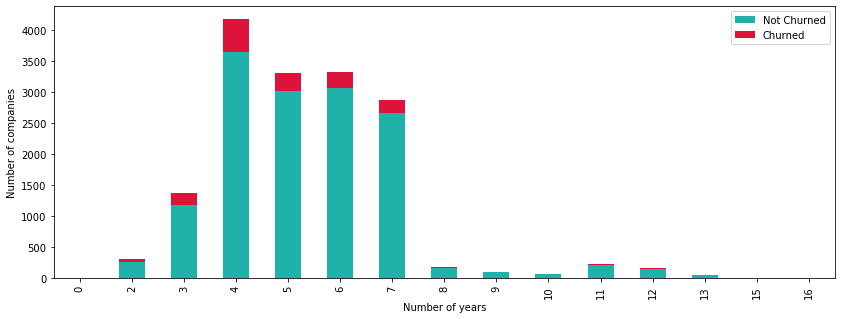

In [64]:
viz_duration = train[['contract_duration','churn','id']].groupby(['contract_duration','churn'])['id'].count().unstack(level=1)
viz_duration.plot(kind='bar', figsize=(14,5), stacked=True, color=['lightseagreen','crimson'])
plt.legend(['Not Churned','Churned'])
plt.xlabel('Number of years')
plt.ylabel('Number of companies');

Churned possibility is lower for recent-joined companies or companies with long history of usage (over 8 years).

Remove date columns as they don't contain any predictive power. Instead, new feature has been created. 

In [65]:
train.drop(['date_activ','date_end','date_modif_prod','date_renewal'], axis=1, inplace=True)

## Transforming Boolean Data

Some categorical data should be converted with numeric values for machine learning model to work --> one hot encoding. 
- has_gas
- channel_sales
- origin_up
- activity_new

In [66]:
# has gas
train['has_gas'] = train['has_gas'].replace({'f': 0, 't': 1}) 

Each category in sales channel should not be mapped to an integer as there is no kind of order or hierarchy. Instead, using get_dummies function of pandas libraries -> one-hot encoding.

In [67]:
# sales channel
channel = pd.get_dummies(train['channel_sales'], prefix='channel')
# cut the columns name to include only 11 characters
channel.columns = [col_name[:11] for col_name in channel.columns]
channel.head(2)

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_mis,channel_sdd,channel_usi
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0


In [68]:
# origin_up
origin = pd.get_dummies(train['origin_up'], prefix='origin')
origin.columns = [col_name[:10] for col_name in origin.columns]
origin.head(2)

,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_mis,origin_usa
0,0,0,1,0,0,0
1,0,0,0,1,0,0


In [69]:
# activity_new
train.activity_new.value_counts().shape[0]

420

In [70]:
cat_activity = pd.DataFrame({"Num_Of_Observations": train["activity_new"].value_counts()})
cat_activity

,Num_Of_Observations
missing,9545
apdekpcbwosbxepsfxclislboipuxpop,1577
kkklcdamwfafdcfwofuscwfwadblfmce,422
kwuslieomapmswolewpobpplkaooaaew,230
fmwdwsxillemwbbwelxsampiuwwpcdcb,219
...,...
exespdalufcdobebbdlcbmbficidkolw,1
lblmkbemolxxlkicccsucmoapesxsplx,1
aacewucldmklslcffeckexipaemmsdfk,1
iuicsodpwomiidiakdpdkxomecpxcdod,1


There are 420 categories for company activity (including missing group). Some of them has only 1 value counts. Categories with less than 75 counts --> group into 1 category.

In [71]:
filtered_index = cat_activity[cat_activity['Num_Of_Observations'] < 75].index
activity = train[train['activity_new'].isin(filtered_index)]
train.loc[activity.index, 'activity_new'] = 'under_75'

In [72]:
# one hot encoding activity_new
activity = pd.get_dummies(train['activity_new'], prefix='activity')
activity.columns = [col_name[:12] for col_name in activity.columns]
activity.head(2)

,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_mis,activity_sff,activity_sfi,activity_und,activity_wxe
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0


In [73]:
# merge
train = pd.merge(train, channel, left_index=True, right_index=True)
train = pd.merge(train, origin, left_index=True, right_index=True)
train = pd.merge(train, activity, left_index=True, right_index=True)

# drop original columns
train.drop(['activity_new','channel_sales','origin_up'], axis=1, inplace=True)

## Log Transformation

Some variables are highly skewed to the right (consumption and forecast amount) --> There are several methods in which skewness is reduced such as square root, cube root, and log. In this case, I will use a log transformation which is usually recommended for right skewed data.

In [74]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,contract_duration,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_mis,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_mis,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_mis,activity_sff,activity_sfi,activity_und,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,0.184145,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,0.000249,0.060015,0.000124,0.458313,0.128790,0.262053,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.005405,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.593004,0.004660,0.005157,0.210984,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,0.387615,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.770392,0.298796,1.749248,0.015763,0.237522,0.011147,0.498275,0.334978,0.439765,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.073322,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.491289,0.068104,0.071626,0.408020,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,0.000000,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,0.000000,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,0.000000,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.0

Observations:
- Standard Deviation is high for some variables.
- Log transformation does not work with negative data --> convert negative values to null.
- Log transformation does not work with 0 --> use 1.

Reference: https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

In [75]:
# change negative values
# train.loc[train.cons_12m < 0,'cons_12m'] = 0
# train.loc[train.cons_gas_12m < 0,'cons_gas_12m'] = 0
# train.loc[train.cons_last_month < 0,'cons_last_month'] = 0
# train.loc[train.forecast_cons_12m < 0,'forecast_cons_12m'] = 0
# train.loc[train.forecast_cons_year < 0,'forecast_cons_year'] = 0
# train.loc[train.forecast_meter_rent_12m < 0,'forecast_meter_rent_12m'] = 0
# # train.loc[train.forecast_price_pow_p1 < 0,'forecast_price_pow_p1'] = 0
# # train.loc[train.margin_gross_pow_ele < 0,'margin_gross_pow_ele'] = 0
# # train.loc[train.margin_net_pow_ele < 0,'margin_net_pow_ele'] = 0
# # train.loc[train.net_margin < 0,'net_margin'] = 0
# train.loc[train.imp_cons < 0,'imp_cons'] = 0

In [76]:
# change negative values
train.loc[train.cons_12m < 0,'cons_12m'] = train.loc[train.cons_12m < 0,'cons_12m'].abs()
train.loc[train.cons_gas_12m < 0,'cons_gas_12m'] = train.loc[train.cons_gas_12m < 0,'cons_gas_12m'].abs()
train.loc[train.cons_last_month < 0,'cons_last_month'] = train.loc[train.cons_last_month < 0,'cons_last_month'].abs()
train.loc[train.forecast_cons_12m < 0,'forecast_cons_12m'] = train.loc[train.forecast_cons_12m < 0,'forecast_cons_12m'].abs()
train.loc[train.forecast_cons_year < 0,'forecast_cons_year'] = train.loc[train.forecast_cons_year < 0,'forecast_cons_year'].abs()
train.loc[train.forecast_meter_rent_12m < 0,'forecast_meter_rent_12m'] = train.loc[train.forecast_meter_rent_12m < 0,'forecast_meter_rent_12m'].abs()
train.loc[train.forecast_price_pow_p1 < 0,'forecast_price_pow_p1'] = train.loc[train.imp_cons < 0,'forecast_price_pow_p1'].abs()
train.loc[train.margin_gross_pow_ele < 0,'margin_gross_pow_ele'] = train.loc[train.imp_cons < 0,'margin_gross_pow_ele'].abs()
train.loc[train.margin_net_pow_ele < 0,'margin_net_pow_ele'] = train.loc[train.imp_cons < 0,'margin_net_pow_ele'].abs()
train.loc[train.net_margin < 0,'net_margin'] = train.loc[train.imp_cons < 0,'net_margin'].abs()
train.loc[train.imp_cons < 0,'imp_cons'] = train.loc[train.imp_cons < 0,'imp_cons'].abs()

In [77]:
# log transformation for highlt skewed data
train['cons_12m'] = np.log10(train['cons_12m']+1)
train['cons_gas_12m'] = np.log10(train['cons_gas_12m']+1)
train['cons_last_month'] = np.log10(train['cons_last_month']+1)
train['forecast_cons_12m'] = np.log10(train['forecast_cons_12m']+1)
train['forecast_cons_year'] = np.log10(train['forecast_cons_year']+1)
train['forecast_meter_rent_12m'] = np.log10(train['forecast_meter_rent_12m']+1)
train['imp_cons'] = np.log10(train['imp_cons']+1)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Ple

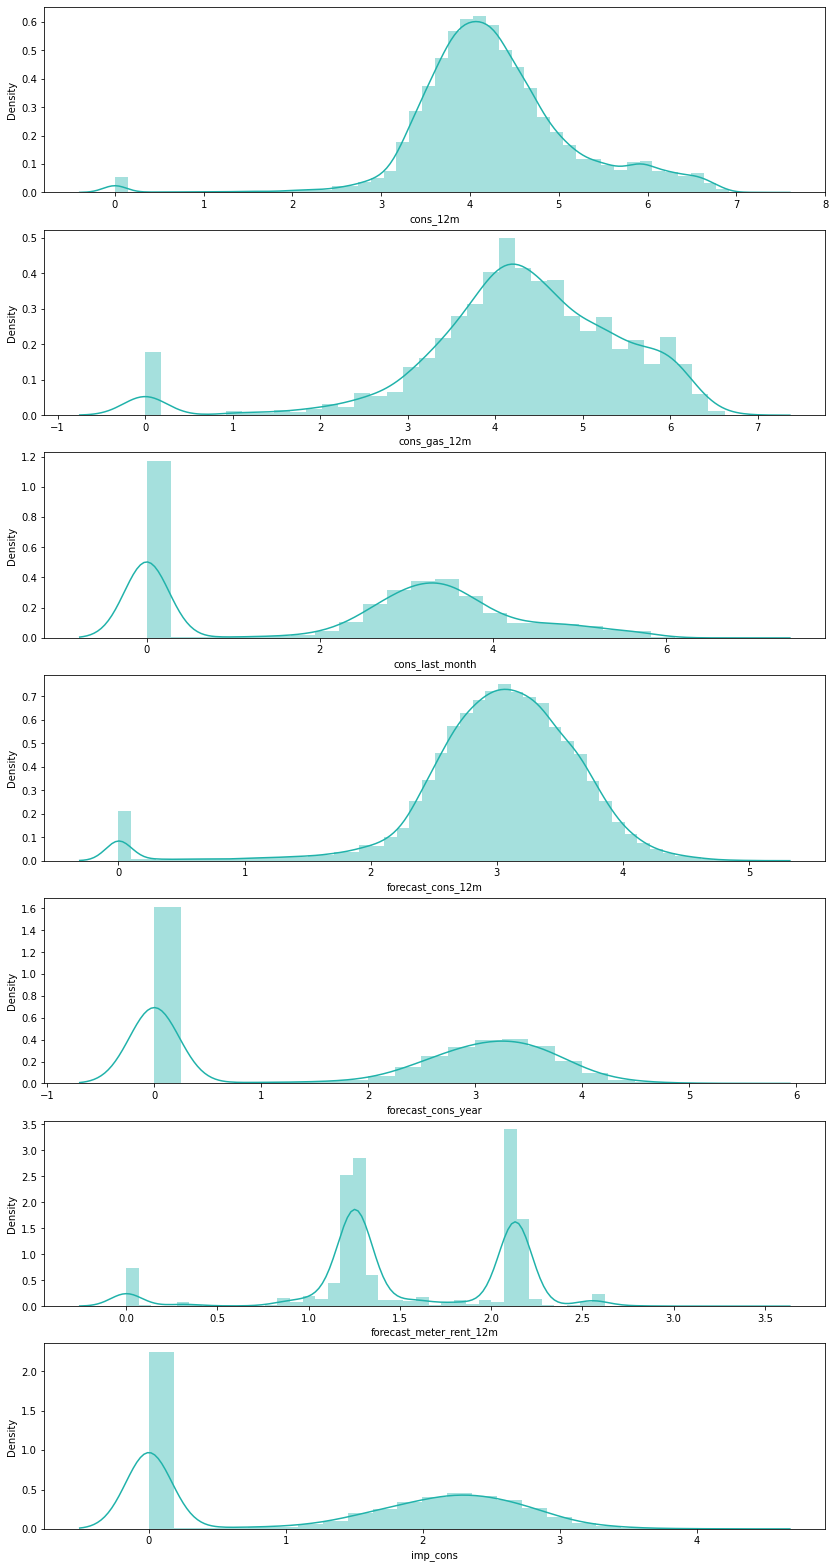

In [78]:
# visualize data after transformation
fig, axs = plt.subplots(nrows=7, figsize=(14,28))

sns.distplot((train['cons_12m'].dropna()), ax=axs[0], color='lightseagreen')
sns.distplot((train[train['has_gas']==1]['cons_gas_12m'].dropna()), ax=axs[1], color='lightseagreen')
sns.distplot((train['cons_last_month'].dropna()), ax=axs[2], color='lightseagreen')
sns.distplot((train['forecast_cons_12m'].dropna()), ax=axs[3], color='lightseagreen')
sns.distplot((train['forecast_cons_year'].dropna()), ax=axs[4], color='lightseagreen')
sns.distplot((train['forecast_meter_rent_12m'].dropna()), ax=axs[5], color='lightseagreen')
sns.distplot((train['imp_cons'].dropna()), ax=axs[6], color='lightseagreen')

plt.show()

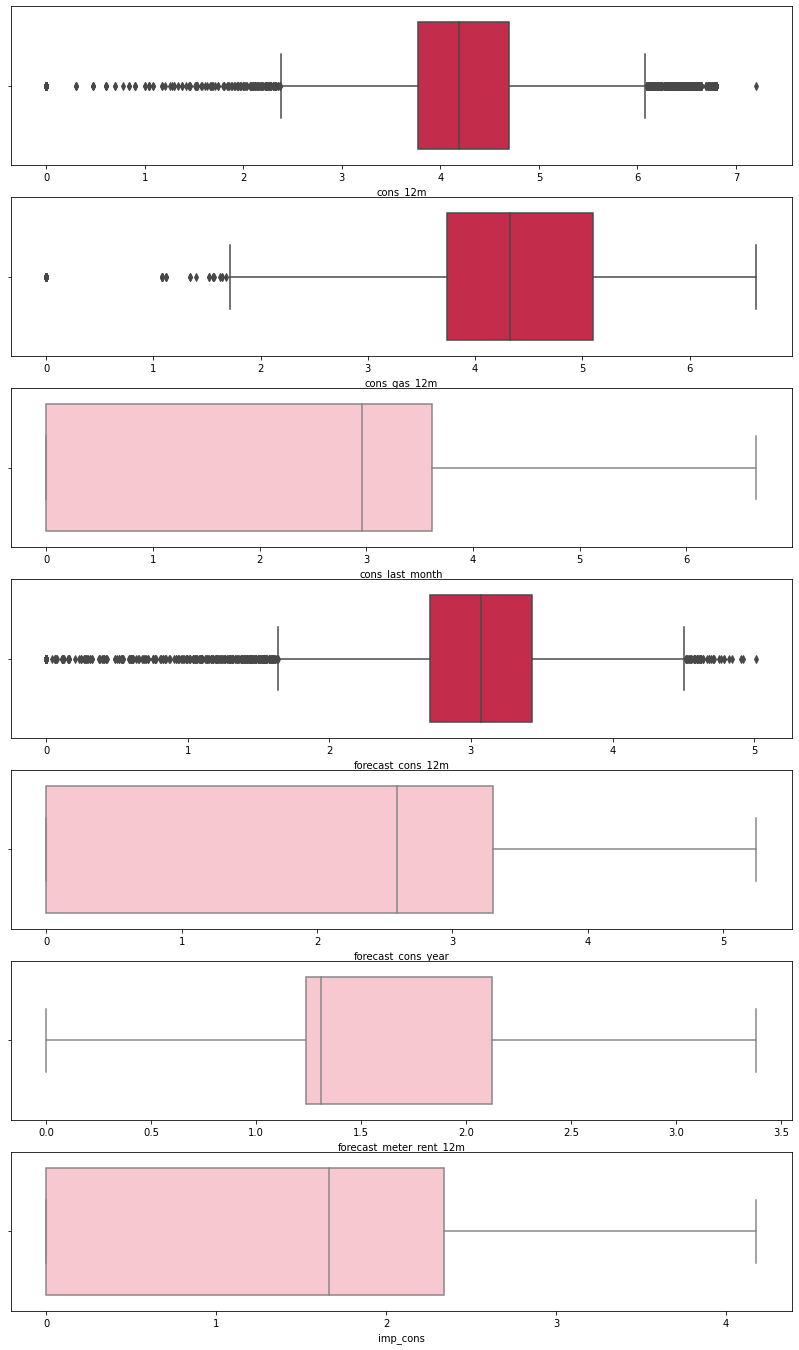

In [79]:
# check again outliers
fig, axs = plt.subplots(nrows=7, figsize=(14,24))

sns.boxplot(x=(train['cons_12m'].dropna()), ax=axs[0], color='crimson')
sns.boxplot(x=(train[train['has_gas']==1]['cons_gas_12m'].dropna()), ax=axs[1], color='crimson')
sns.boxplot(x=(train['cons_last_month'].dropna()), ax=axs[2], color='pink')
sns.boxplot(x=(train['forecast_cons_12m'].dropna()), ax=axs[3], color='crimson')
sns.boxplot(x=(train['forecast_cons_year'].dropna()), ax=axs[4], color='pink')
sns.boxplot(x=(train['forecast_meter_rent_12m'].dropna()), ax=axs[5], color='pink')
sns.boxplot(x=(train['imp_cons'].dropna()), ax=axs[6], color='pink');

Observations:
- The data is closer to normal distribution; however, there are some variables with outliers.
- Outliers will be replaced by average (exclude outliers).

## Remove Outliers

Fill NaN and outliers with average value.

In [80]:
from scipy.stats import zscore
def replace_outliers_zscore(df, col):
    data = df.copy(deep=True) # deep=True avoid changes to the origial dataset
    data.dropna(inplace=True, subset=[col])
    
    data['zscore'] = zscore(data[col])
    avg = data[(data['zscore'] > -3) & (data['zscore'] < 3)][col].mean()
    
    df[col] = df[col].fillna(avg)
    df['zscore'] = zscore(df[col])
    df.loc[(df['zscore'] < -3) | (df['zscore'] > 3), col] = avg
    removed = df[(df['zscore'] < -3) | (df['zscore'] > 3)].shape
    
    print('Replace {} outliers in {}'.format(removed[0], col))
    return df.drop(columns='zscore')

In [81]:
cols = ['cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 
       'net_margin', 'pow_max']
for c in cols:
    train = replace_outliers_zscore(train, c)

Replace 175 outliers in cons_12m
Replace 118 outliers in cons_gas_12m
Replace 0 outliers in cons_last_month
Replace 426 outliers in forecast_cons_12m
Replace 575 outliers in forecast_discount_energy
Replace 1 outliers in forecast_meter_rent_12m
Replace 300 outliers in forecast_price_energy_p1
Replace 0 outliers in forecast_price_energy_p2
Replace 239 outliers in forecast_price_pow_p1
Replace 263 outliers in margin_gross_pow_ele
Replace 250 outliers in margin_net_pow_ele
Replace 182 outliers in net_margin
Replace 293 outliers in pow_max


In [82]:
train.reset_index(drop=True, inplace=True)

In [83]:
# remove outliers for price data
for c in price_12m.columns:
    if c!= 'id':
        price_12m = replace_outliers_zscore(mean_12m, c)

Replace 276 outliers in mean_12m_price_p1_var
Replace 0 outliers in mean_12m_price_p2_var
Replace 0 outliers in mean_12m_price_p3_var
Replace 120 outliers in mean_12m_price_p1_fix
Replace 0 outliers in mean_12m_price_p2_fix
Replace 0 outliers in mean_12m_price_p3_fix
Replace 122 outliers in mean_price_12m_p1
Replace 0 outliers in mean_price_12m_p2
Replace 0 outliers in mean_price_12m_p3


In [84]:
price_12m.reset_index(drop=True, inplace=True)

## Finalized Dataset

In [85]:
# merge price data to training data
cust_data = pd.merge(train, price_12m, on='id')
cust_data.head(2)

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,contract_duration,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_mis,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_mis,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_mis,activity_sff,activity_sfi,activity_und,activity_wxe,mean_12m_price_p1_var,mean_12m_price_p2_var,mean_12m_price_p3_var,mean_12m_price_p1_fix,mean_12m_price_p2_fix,mean_12m_price_p3_fix,mean_price_12m_p1,mean_price_12m_p2,mean_price_12m_p3
0,48ada52261e7cf58715202705a0451c9,5.490346,0.000000,4.001128,4.423595,4.001128,0.0,2.556652,0.095919,0.088347,58.995952,0,2.920541,22.829193,22.772809,1,199.886637,3,18.40333,0,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,59.059950,36.449002,8.404292
1,24011ae4ebbe3035111d65fa7c15bc57,4.325649,4.739944,0.000000,3.084341,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,1,0.000000,25.440000,25.440000,2,678.990000,3,43.64800,1,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871


In [86]:
cust_data.shape

(16096, 56)

## Correlation

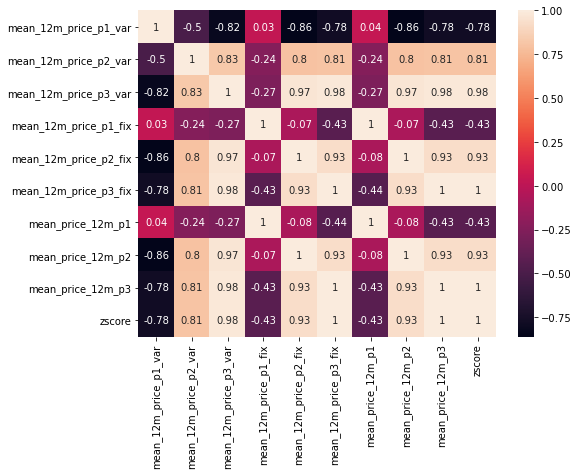

In [87]:
cor1 = mean_12m.corr().round(2)

# plot correlation
plt.figure(figsize=(8,6))
sns.heatmap(cor1, xticklabels=cor1.columns, yticklabels=cor1.columns, annot=True);

Observations:
- Multicollinearity happens perfectly: mean_price_12m_p1 with mean_price_12m_p1_fix # same with p2 and p3.
- Decision Tree and boosted trees algorithms are immune to multicollinearity.
- Logistics Regression with such problem produces skewed/misleading result.

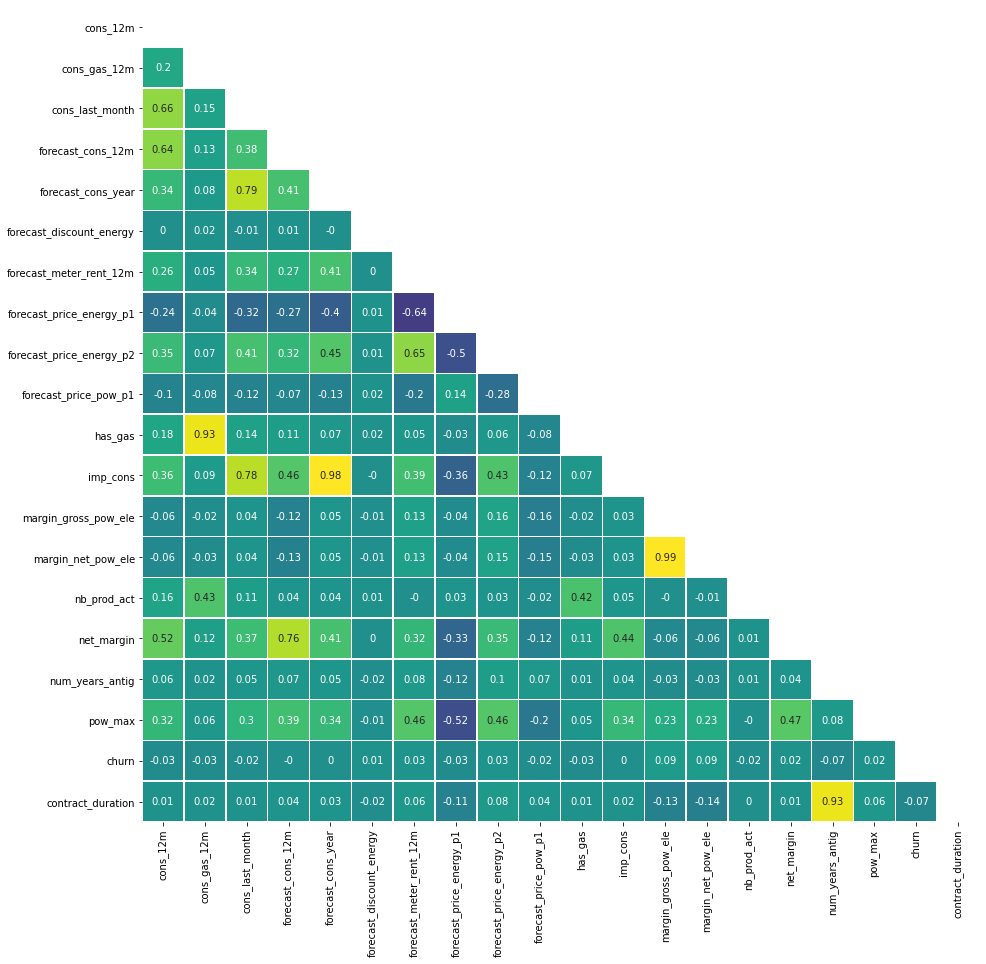

In [93]:
cor2 = train.iloc[:,:21].corr().round(2)

# plot correlation
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(cor2, dtype=bool))
sns.heatmap(cor2, mask=mask, center=0, cmap='viridis', linewidths=.5,annot=True, cbar=False);

Observations:

imp_cons and forecast_cons_year have high 98% correlation --> drop imp_cons, forecast_cons_year
contract_duration and num_years_antig have 93% correlation --> drop num_years_antig

In [94]:
train.drop(['forecast_cons_year','imp_cons','num_years_antig'], axis=1, inplace=True)

## Predictive Model

In [95]:
# X, y
df = cust_data.copy()
y = df['churn']
X = df.drop(columns=['id','churn'])

In [96]:
# Split the dataset into training, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=221)

Each model is built and evaluate based on:
- Accuracy: the ratio of correct prediction over total observation
- Recall: the ratio of correct positive prediction over all observation s in actual class.
- Precision: the ratio of correct positive prediction over total positive observations
- Confusion Matrix

------------------------------------------
Performance on Test Set
------------------------------------------
83.87% accuracy can be achieved through decision tree

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4371
           1       0.20      0.24      0.22       458

    accuracy                           0.84      4829
   macro avg       0.56      0.57      0.56      4829
weighted avg       0.85      0.84      0.84      4829



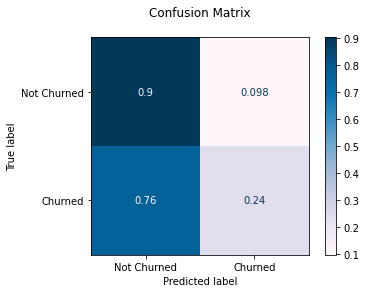

In [97]:
# decision tree
dt = DecisionTreeClassifier(criterion='gini', random_state=221).fit(X_train, y_train)
y_pred_dt_test = dt.predict(X_test)

# performance
print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
acc_score_test = accuracy_score(y_test, y_pred_dt_test)
print('{:.2f}% accuracy can be achieved through decision tree\n'.format(acc_score_test*100))

# classification report
print(classification_report(y_test, y_pred_dt_test))

# confusion matrix
plot_confusion_matrix(dt, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Churned','Churned'])
plt.title('Confusion Matrix\n');

Accuracy scores are high. However, out of all churned cases, only 26% cases are predict correctly. To check whether the tree is bias as it mostly predict Non-Churn due to imbalanced dataset, the same model is use for balanced dataset by SMOTE.

------------------------------------------
Performance on Test Set
------------------------------------------
83.87% accuracy can be achieved through decision tree

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4371
           1       0.20      0.24      0.22       458

    accuracy                           0.84      4829
   macro avg       0.56      0.57      0.56      4829
weighted avg       0.85      0.84      0.84      4829



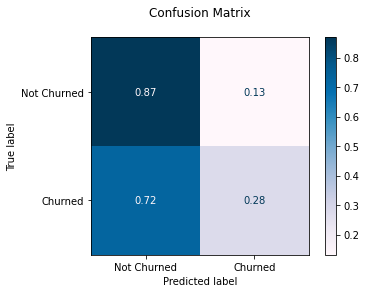

In [98]:
# balancing data
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

# decision tree model
dt_bal = DecisionTreeClassifier(criterion='gini', random_state=123).fit(X_sm, y_sm)
y_pred_dt_bal_test = dt.predict(X_test)

# performance
print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
acc_score_bal_test = accuracy_score(y_test, y_pred_dt_bal_test)
print('{:.2f}% accuracy can be achieved through decision tree\n'.format(acc_score_bal_test*100))

# classification report
print(classification_report(y_test, y_pred_dt_bal_test))

# confusion matrix
plot_confusion_matrix(dt_bal, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Churned','Churned'])
plt.title('Confusion Matrix\n');

Balanced dataset does not provide much different on the performance.

------------------------------------------
Performance on Test Set
------------------------------------------
90.97% accuracy can be achieved through random forest

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4371
           1       0.89      0.05      0.10       458

    accuracy                           0.91      4829
   macro avg       0.90      0.53      0.53      4829
weighted avg       0.91      0.91      0.87      4829



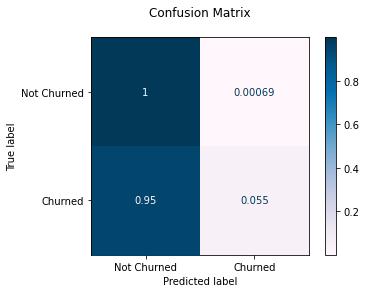

In [99]:
# random forest
rf = RandomForestClassifier(n_estimators=300, criterion='gini', random_state=221).fit(X_train, y_train)
y_pred_rf_test = rf.predict(X_test)

# performance
print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
acc_score_test = accuracy_score(y_test, y_pred_rf_test)
print('{:.2f}% accuracy can be achieved through random forest\n'.format(acc_score_test*100))

# classification report
print(classification_report(y_test, y_pred_rf_test))

# confusion matrix
plot_confusion_matrix(rf, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Churned','Churned'])
plt.title('Confusion Matrix\n');

The model has higher accuracy but fails to distinguish Churned cases. Only 6% of churned cases are predicted correctly --> overfitting.

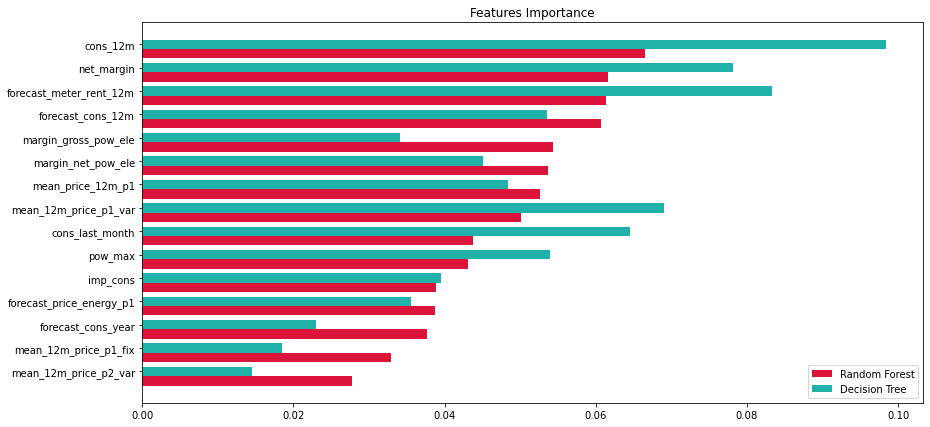

In [100]:
features = pd.DataFrame({'rf': rf.feature_importances_,
                    'dt': dt.feature_importances_}, index=X.columns)
features = features.sort_values(by='rf', ascending=True)
fea_viz = features.iloc[-15:].copy()
index = np.arange(len(fea_viz))
fig, ax = plt.subplots(figsize=(14,7))
rf_viz = ax.barh(index, fea_viz['rf'], 0.4, color='crimson', label='Random Forest')
dt_viz = ax.barh(index+0.4, fea_viz['dt'], 0.4, color='lightseagreen', label='Decision Tree')
ax.set(yticks=index+0.4, yticklabels=fea_viz.index)
ax.set_title('Features Importance')

ax.legend();

Both decision tree and random forest treats electricity consumption for the past 12 months and total net margin as key influencers to the models.

In [97]:
# # gradient boosting
# gb = GradientBoostingClassifier(n_estimators=300, random_state=123).fit(X_train, y_train)
# y_pred_gb_test = gb.predict(X_test)

# print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
# acc_score_test = accuracy_score(y_test, y_pred_gb_test)
# print('{:.2f}% accuracy can be achieved through gradient boosting\n'.format(acc_score_test*100))

# # classification report
# print(classification_report(y_test, y_pred_gb_test))

# # confusion matrix
# plot_confusion_matrix(gb, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Churned','Churned'])
# plt.title('Confusion Matrix (Test Set)\n');

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------------------
Performance on Test Set
------------------------------------------
90.62% accuracy can be achieved through XGBoosting

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4371
           1       0.57      0.04      0.08       458

    accuracy                           0.91      4829
   macro avg       0.74      0.52      0.52      4829
weighted avg       0.88      0.91      0.87      4829



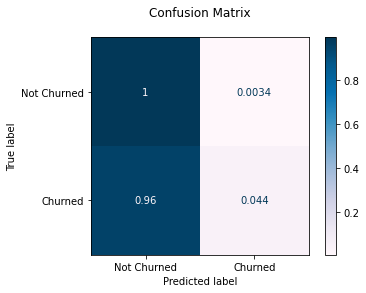

In [101]:
xg = xgb.XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=300, n_jobs=-1).fit(X_train, y_train)
y_pred_xgb_test = xg.predict(X_test)

# performance
print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
acc_score_test = accuracy_score(y_test, y_pred_xgb_test)
print('{:.2f}% accuracy can be achieved through XGBoosting\n'.format(acc_score_test*100))

# classification report
print(classification_report(y_test, y_pred_xgb_test))

# confusion matrix
plot_confusion_matrix(xg, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Churned','Churned'])
plt.title('Confusion Matrix\n');

The model behaves much similar to Random Forest. Let's fine tune to improve the performance.

### Fine tune model

In [102]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'min_child_weight': [i for i in np.arange(1,15,1)],
    'gamma': [i for i in np.arange(0,6,0.5)],
    'subsample': [i for i in np.arange(0,1.1,0.1)],
    'colsample_bytree': [i for i in np.arange(0,1.1,0.1)],
    'max_depth': [i for i in np.arange(1,15,1)],
    'scale_pos_weight': [i for i in np.arange(1,15,1)],
    'learning_rate': [i for i in np.arange(0,0.1,0.01)],
    'n_estimators': [i for i in np.arange(0,2000,100)]
}

xg = xgb.XGBClassifier(objective='binary:logistic', silent=True, nthread=1)
xg_random = RandomizedSearchCV(xg, param_distributions=params,
                              n_iter=1, scoring='roc_auc', n_jobs=4, cv=5, verbose=3, random_state=221)

xg_random.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                        

In [103]:
best_random = xg_random.best_params_
best_random

{'subsample': 0.1,
 'scale_pos_weight': 12,
 'n_estimators': 900,
 'min_child_weight': 10,
 'max_depth': 5,
 'learning_rate': 0.01,
 'gamma': 4.5,
 'colsample_bytree': 0.2}

[17:54:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------------------
Performance on Test Set
------------------------------------------
66.58% accuracy can be achieved through XGBoosting

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      4371
           1       0.16      0.61      0.26       458

    accuracy                           0.67      4829
   macro avg       0.55      0.64      0.52      4829
weighted avg       0.87      0.67      0.73      4829



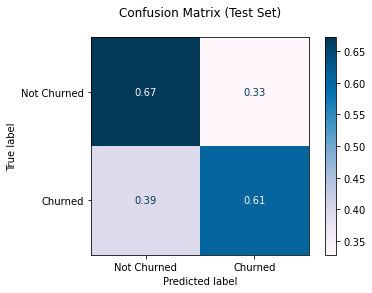

In [104]:
model_random = xgb.XGBClassifier(objective='binary:logistic', nthread=1, **best_random).fit(X_train, y_train)
y_pred_xgb_test = model_random.predict(X_test)

# performance
print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
acc_score_test = accuracy_score(y_test, y_pred_xgb_test)
print('{:.2f}% accuracy can be achieved through XGBoosting\n'.format(acc_score_test*100))

# classification report
print(classification_report(y_test, y_pred_xgb_test))

# confusion matrix
plot_confusion_matrix(model_random, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Churned','Churned'])
plt.title('Confusion Matrix (Test Set)\n');

Although the accuracy score is low, my goal is to identify as much churned cases as possible. This model has the best performance so far as it can predict 65% of churned cases correctly. 

## Evaluate Performance

In [105]:
y_pred_proba_dt = dt.predict_proba(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)
y_pred_proba_dt_bal = dt_bal.predict_proba(X_test)
y_pred_proba_xgb = model_random.predict_proba(X_test)
# y_pred_proba_gb = gb.predict_proba(X_test)

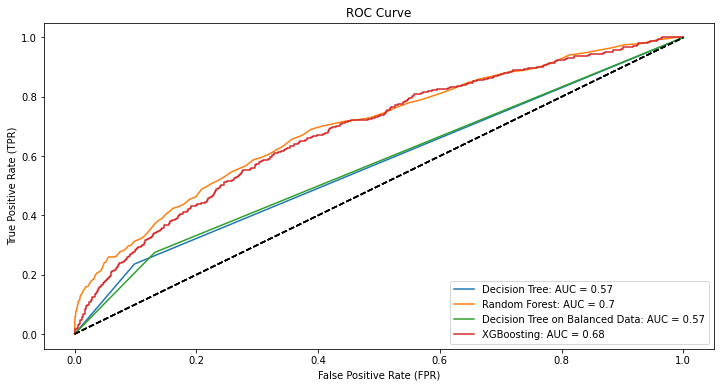

In [106]:
plt.figure(figsize=(12,6))

for test, pred, name in zip([y_test, y_test, y_test, y_test], [y_pred_proba_dt[:,1], y_pred_proba_rf[:,1], y_pred_proba_dt_bal[:,1], y_pred_proba_xgb[:,1]], 
                            ['Decision Tree', 'Random Forest', 'Decision Tree on Balanced Data','XGBoosting']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 2)))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC Curve')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)');

Random Forest have the highest AUC score, but its performance are bad (correctly predict churned in Confusion Matrix). XGBoosting has relatively high AUC. The ROC curve shows how much the model is capable of differentiating classes.

Therefore, XGBoosting model is chosen.

### Feature Importance

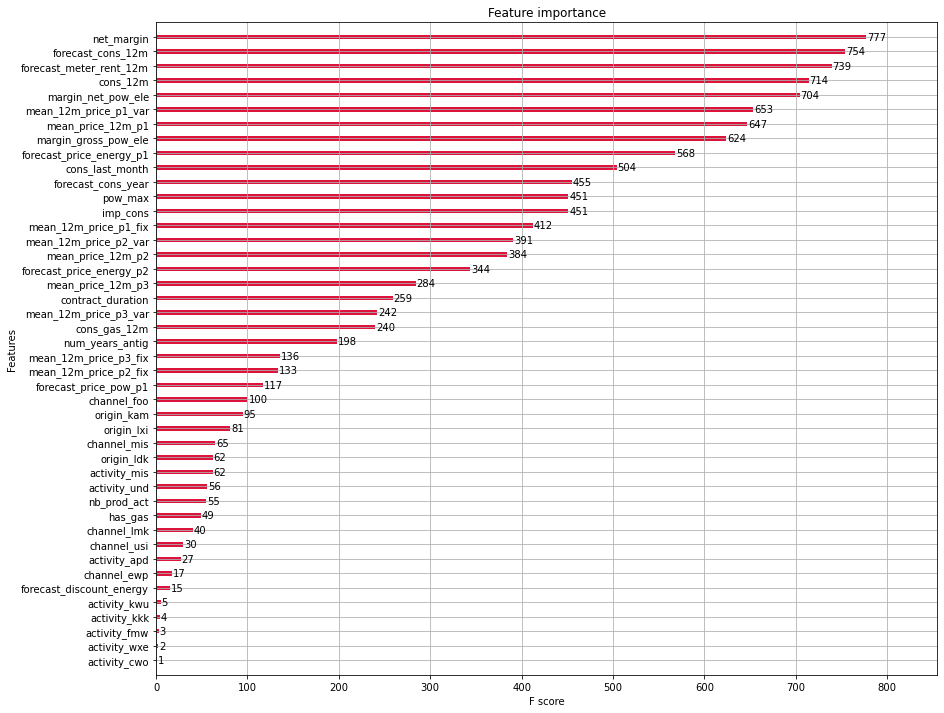

In [107]:
fig, ax = plt.subplots(figsize = (14,12))
xgb.plot_importance(model_random, ax=ax, color='crimson', height=0.3);

Electricity consumption of the past 12 months and gross margin on power subscription are the key influencers to retention rate in this XGB model. 

### Shap Feature Importance

In [108]:
explainer = shap.TreeExplainer(model_random)
s_values = explainer.shap_values(X_test)

In [109]:
# shap.summary_plot(s_values, X_test, plot_type='bar', color='lightseagreen');

Top 3 important features are very similar to XGB. Random Forest model is much in contrast to XGB when treating each category for the classification.

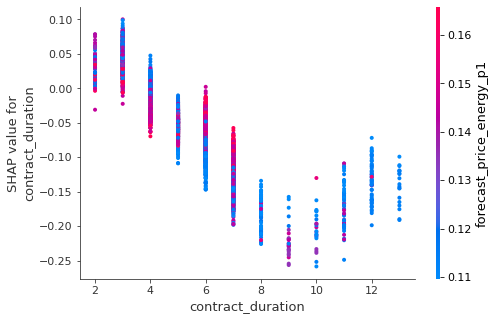

In [110]:
shap.dependence_plot('contract_duration', s_values, X_test)

There is a clear pattern for the contract duration. The longer the contract, the less likely the company churns. Around 9 years on ward, the churn possibility increased again.

## Single Prediction

In [111]:
shap.initjs()
shap.force_plot(explainer.expected_value, s_values[3200], X_test.iloc[3200,:], link="logit")

In [112]:
shap.initjs()
shap.force_plot(explainer.expected_value, s_values[3000], X_test.iloc[3000,:], link="logit")

In [113]:
shap.initjs()
shap.force_plot(explainer.expected_value, s_values[67], X_test.iloc[77,:], link="logit")

This figure shows how different features interacted to result in the predictive model. The lower values of the margin_net_pow_ele and margin_gross_pow_ele, the less likely the customer churns.

## In conclusion

- Churn rate is about 10%.
- Churned cases can be identified by the model. However, price sensitivity is not the main driver as initial consumption. Instead, electricity yearly consumption, net margin on power subscription and forecasted electricity consumption for the next year are key drivers. 
- Discount strategy is effective only when applying to the appropriate target:
    - *Customer with more than 9-year tenure.* 
    - *Customer with high amount consumption.*